In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.keras.layers import Dense,Input,LSTM,GlobalMaxPooling1D,Embedding,MaxPooling1D,Conv1D,Concatenate,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

In [3]:
from tensorflow.keras.layers import Dense,Input,LSTM,GlobalMaxPooling1D,Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files

In [7]:
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          10175        302  1.0              
thedevastator/mcdonalds-ice-cream-machines-broken-timeseries   McDonalds Ice Cream Machines Breaking - Timeseries  404KB  2022-09-14 23:51:09            986         37  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           2603  

In [8]:
! kaggle competitions download -c dogs-vs-cats

 98% 793M/812M [00:20<00:00, 39.4MB/s]
100% 812M/812M [00:20<00:00, 42.0MB/s]


In [9]:
!unzip -qq dogs-vs-cats.zip 

In [10]:
label_mapper ={1 : "dog", 0 : "cat"}

In [11]:
!unzip -qq './train.zip'

In [12]:
files = glob('./train/*')

files_name,labels = list(),list()
for f in files:
    label_name = (f.split('/')[2]).split('.')[0]
    files_name.append((f.split('/')[2]))
    labels.append(label_name)
    
df1= pd.DataFrame({'filename':files_name, 'label':labels})

In [13]:
df1.head()

,filename,label
0,dog.2812.jpg,dog
1,dog.11374.jpg,dog
2,cat.3923.jpg,cat
3,cat.3509.jpg,cat
4,dog.899.jpg,dog


In [14]:
train_path="./train"

IMAGE_SIZE=[150, 150]

image_files=glob(train_path+"/*.jpg")


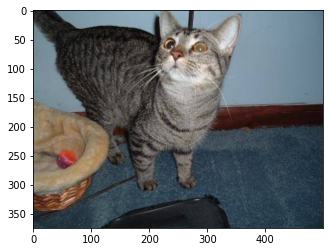

In [15]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [16]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
ptm.trainable=False

In [18]:
K=2
x = Flatten()(ptm.output)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x=Dense(K,activation='softmax')(x)

In [19]:
model = Model(inputs=ptm.input,outputs=x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [21]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(df1, test_size=0.2,random_state=42)

In [22]:
gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range= 15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)
batch_size=32


training_data = gen.flow_from_dataframe(dataframe=train_set, 
                                                        directory='./train',
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=IMAGE_SIZE,
                                                       class_mode='categorical',
                                                       batch_size=batch_size)


Found 20000 validated image filenames belonging to 2 classes.


In [23]:
valid_datagenerator = ImageDataGenerator(rescale=1./255)
validation_data = valid_datagenerator.flow_from_dataframe(dataframe=valid_set,
                                                         directory='./train',
                                                         x_col='filename',
                                                         y_col='label',
                                                         target_size=IMAGE_SIZE,
                                                         class_mode='categorical',
                                                         batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.01,momentum=0.9),
    metrics='accuracy'
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [25]:
r = model.fit_generator(
    training_data,
    validation_data=validation_data,
    epochs=4,
    steps_per_epoch=train_set.shape[0]//batch_size,
    validation_steps=valid_set.shape[0]//batch_size
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/4
625/625 [==============================] - 177s 264ms/step - loss: 0.4208 - accuracy: 0.7967 - val_loss: 0.3399 - val_accuracy: 0.8722
Epoch 2/4
625/625 [==============================] - 163s 260ms/step - loss: 0.3751 - accuracy: 0.8343 - val_loss: 0.2517 - val_accuracy: 0.8972
Epoch 3/4
625/625 [==============================] - 162s 259ms/step - loss: 0.3517 - accuracy: 0.8475 - val_loss: 0.2409 - val_accuracy: 0.8942
Epoch 4/4
625/625 [==============================] - 162s 259ms/step - loss: 0.3311 - accuracy: 0.8534 - val_loss: 0.3301 - val_accuracy: 0.9026


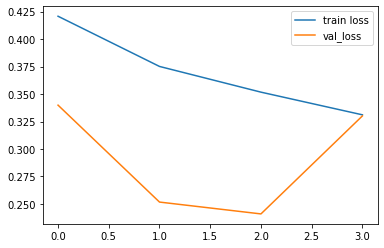

In [26]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

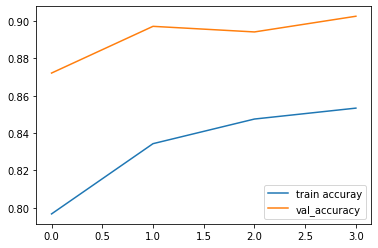

In [27]:
plt.plot(r.history['accuracy'],label='train accuray')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [28]:
model.save('transfer_model_dog_cat.h5')

In [39]:
from tensorflow.keras.layers import *
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential()

model.add(DefaultConv2D(filters=32, kernel_size=5, input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=64))
model.add(DefaultConv2D(filters=64))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=128))
model.add(DefaultConv2D(filters=128))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


In [40]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.01,momentum=0.9),
    metrics='accuracy'
)

In [48]:
r = model.fit_generator(
    training_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_set.shape[0]//batch_size,
    validation_steps=valid_set.shape[0]//batch_size
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
625/625 [==============================] - 157s 251ms/step - loss: 0.2254 - accuracy: 0.9071 - val_loss: 0.3442 - val_accuracy: 0.8460
Epoch 2/10
625/625 [==============================] - 155s 247ms/step - loss: 0.2204 - accuracy: 0.9097 - val_loss: 0.3778 - val_accuracy: 0.8293
Epoch 3/10
625/625 [==============================] - 154s 247ms/step - loss: 0.2170 - accuracy: 0.9089 - val_loss: 0.3800 - val_accuracy: 0.8327
Epoch 4/10
625/625 [==============================] - 154s 246ms/step - loss: 0.2055 - accuracy: 0.9133 - val_loss: 0.3135 - val_accuracy: 0.8664
Epoch 5/10
625/625 [==============================] - 155s 247ms/step - loss: 0.1961 - accuracy: 0.9199 - val_loss: 0.3674 - val_accuracy: 0.8492
Epoch 6/10
625/625 [==============================] - 162s 259ms/step - loss: 0.1951 - accuracy: 0.9186 - val_loss: 0.3450 - val_accuracy: 0.8570
Epoch 7/10
625/625 [==============================] - 154s 246ms/step - loss: 0.1912 - accuracy: 0.9207 - val_loss: 0.4679 -

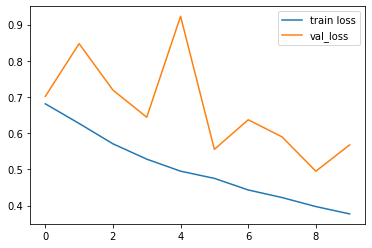

In [43]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

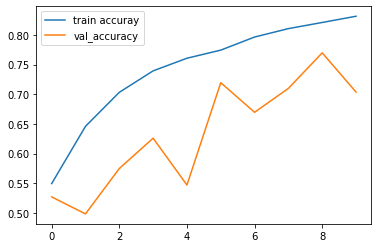

In [44]:
plt.plot(r.history['accuracy'],label='train accuray')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

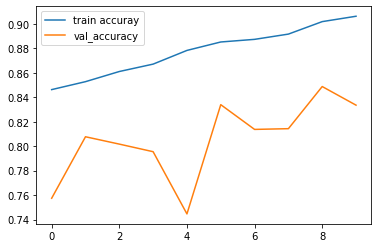

In [46]:
plt.plot(r.history['accuracy'],label='train accuray')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

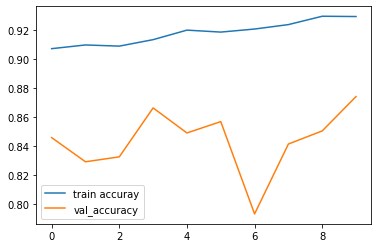

In [49]:
plt.plot(r.history['accuracy'],label='train accuray')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [50]:
model.save('handmade_model_dog_cat3.h5')